In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pointbiserialr, pearsonr
from natsort import natsort_keygen
from itertools import combinations

## Plotting parameters

In [3]:
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

FIGWIDTH = 7.00697
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
N_TRIALS = 20

# green for gpt-4v, gray for fuyu, purple for adapter, teal for otter, red for humans
model_colors = [
    "#50b990",
    "#8c92ac",
    "#624fe8",
    "#008080",
    "#9b443e",
]

cmap = [
    "#9b443e",
    "#53665c",
    "#ccb3a0",
    "#f4b368",
    "#a08158",
    "#c87858",
    "#94b1d2",
    "#c5d9d8",
    "#e6b951",
    "#666666",
]
sns.set_palette(cmap)


plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


latex_context = {
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
}


# retina figures
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300

## Data wrangling

In [4]:
# Prepare data frame
df = pd.DataFrame().astype("object")
df["Image"] = np.tile(np.arange(1,517,1), 3)
df["Experiment"] = np.repeat([1, 2, 3], 516)

# Load our own collected data (GPT-4V, Fuyu, LLaMA-Adapter v2)
results = pd.read_csv("data/LERER_RESULTS.csv").loc[:, :"OTTER"]

# Define subjects
subjects = results.columns[2:]
for subject in subjects:
    df[subject] = np.zeros(df.shape[0])
    df[subject] = np.nan

# Loop through result data frame
for row in range(results.shape[0]):
    ind = np.where((df["Image"] == results["Image"][row]) & (df["Experiment"] == results["Experiment"][row]))[0][0]
    for subject in subjects:
        df.loc[ind, subject] = results[subject][row]

# Preview combined dataframe
df.iloc[-10:,]

/var/folders/bn/2pj3hkgj62q9k4k5frvs6rbc0000gn/T/ipykernel_15939/2340078446.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'White' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[ind, subject] = results[subject][row]


,Image,Experiment,GT,GPT-4V,GPT-4V-B,FUYU,ADAPTER,OTTER
1538,507,3,NaN,NaN,NaN,NaN,NaN,NaN
1539,508,3,NaN,NaN,NaN,NaN,NaN,NaN
1540,509,3,1,80,0,NaN,1,1
1541,510,3,0,1,0,1,1,1
1542,511,3,NaN,NaN,NaN,NaN,NaN,NaN
1543,512,3,NaN,NaN,NaN,NaN,NaN,NaN
1544,513,3,NaN,NaN,NaN,NaN,NaN,NaN
1545,514,3,NaN,NaN,NaN,NaN,NaN,NaN
1546,515,3,NaN,NaN,NaN,NaN,NaN,NaN
1547,516,3,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Exclude faulty trials if wanted
clean = True
if clean:

    # Get sequence numbers from Lerer code
    exclude = [84, 85, 86, 87, 88, 89, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 367, 368, 369, 370]
    print(f"Shape before cleaning: {df.shape}")
    df = df[df["Image"].isin(exclude) != True]
    print(f"Shape after cleaning: {df.shape}")

# As sanity check, check if sequences are really removed
errors = np.sum(np.isin(df["Image"], exclude))
print(f"Remaining errors: {errors}. If this is not 0, something went wrong.")
# df = df.reindex(np.arange(df.shape[0]), axis="index")

Shape before cleaning: (1548, 8)
Shape after cleaning: (1479, 8)
Remaining errors: 0. If this is not 0, something went wrong.


In [6]:
# Load human data from Lerer
lerer_humans = np.load("data/lerer_humans.npy")

# Get the correct sequence numbers
sequences = np.arange(1, 517)
exclude = [84, 85, 86, 87, 88, 89, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 367, 368, 369, 370]
sequences = sequences[np.isin(sequences, exclude) != True]

# Make into pandas data frame
lerer_humans = np.hstack((np.expand_dims(sequences, 1), lerer_humans))
lerer = pd.DataFrame(data=lerer_humans[0:,0:], 
                     index=[i for i in range(lerer_humans.shape[0])], 
                     columns=["Image", "GT", "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10"])

In [7]:
# Add human subjects to dataframe
subjects = lerer.columns[2:]
for subject in subjects:
    df[subject] = np.zeros(df.shape[0])
    df[subject] = np.nan

# Loop through result data frame
for row in range(lerer.shape[0]):
    ind = df.iloc[np.where((df["Image"] == lerer["Image"][row]) & (df["Experiment"] == 3))[0][0]].name
    for subject in subjects:
        df.at[ind, subject] = lerer.at[row, subject]

df.iloc[-10:,:]

,Image,Experiment,GT,GPT-4V,GPT-4V-B,FUYU,ADAPTER,OTTER,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10
1538,507,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,0.0
1539,508,3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1540,509,3,1,80,0,NaN,1,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1541,510,3,0,1,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1542,511,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
1543,512,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN
1544,513,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
1545,514,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1546,515,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1547,516,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0


## Analyses

#### Simple accuracies

In [8]:
# Define subjects
subjects = ("GPT-4V-B", "FUYU", "ADAPTER", "OTTER")

# Pre-allocate data frame for first three experiments
percentages_correct = pd.DataFrame()
percentages_correct["Experiment"] = np.arange(1,4)

# Check accuracy for all different agents
for subj_ind, subject in enumerate(subjects):

    # Add subject to percentages correct data frame
    percentages_correct[f"{subject}"] = np.zeros(3)

    # Loop through experiments
    for exp in range(3):

        # Get rows for experiment and then subject and ground truth data
        exp_subj_data = df.loc[df["Experiment"] == exp+1, subject]
        exp_gt_data = df.loc[df["Experiment"] == exp+1, "GT"]

        # Calculate percentages correct
        percentages_correct.iloc[exp, subj_ind+1] = (sum(exp_gt_data.values == exp_subj_data.values) / len(exp_gt_data.dropna().values)).astype(float)

        # Calculate difference
        print(f"Experiment {exp+1}: {subject} got {sum(exp_gt_data.values == exp_subj_data.values)} out of {len(exp_gt_data.dropna().values)} " + 
            f"(accuracy: {percentages_correct.iloc[exp, subj_ind+1]:.4f})")

Experiment 1: GPT-4V-B got 93 out of 93 (accuracy: 1.0000)
Experiment 2: GPT-4V-B got 93 out of 93 (accuracy: 1.0000)
Experiment 3: GPT-4V-B got 55 out of 93 (accuracy: 0.5914)
Experiment 1: FUYU got 93 out of 93 (accuracy: 1.0000)
Experiment 2: FUYU got 43 out of 93 (accuracy: 0.4624)
Experiment 3: FUYU got 42 out of 93 (accuracy: 0.4516)
Experiment 1: ADAPTER got 91 out of 93 (accuracy: 0.9785)
Experiment 2: ADAPTER got 33 out of 93 (accuracy: 0.3548)
Experiment 3: ADAPTER got 46 out of 93 (accuracy: 0.4946)
Experiment 1: OTTER got 93 out of 93 (accuracy: 1.0000)
Experiment 2: OTTER got 14 out of 93 (accuracy: 0.1505)
Experiment 3: OTTER got 47 out of 93 (accuracy: 0.5054)


#### Human accuracy for stability

In [9]:
human_accs = np.zeros(10)
for ind, subject in enumerate(lerer.columns[2:]):

    # Get rows for experiment and then subject and ground truth data
    exp_subj_data = lerer[subject].values.astype(float)
    exp_gt_data = lerer["GT"].values.astype(float)

    # Get all indices where at least one value is nan and calculate Cohen Kappa
    na = np.logical_or(np.isnan(exp_gt_data), np.isnan(exp_subj_data))
    human_accs[ind] = sum(np.equal(exp_gt_data[~na], exp_subj_data[~na])) / len(exp_gt_data[~na])
    print(f"Experiment 3: {subject} got {sum(np.equal(exp_gt_data[~na], exp_subj_data[~na]))} out of {len(exp_gt_data[~na])} (accuracy: {human_accs[ind]:.2f})")
print(f"Experiment 3: mean accuracy {human_accs.mean():.2f}")

Experiment 3: H1 got 68 out of 100 (accuracy: 0.68)
Experiment 3: H2 got 68 out of 100 (accuracy: 0.68)
Experiment 3: H3 got 71 out of 100 (accuracy: 0.71)
Experiment 3: H4 got 80 out of 100 (accuracy: 0.80)
Experiment 3: H5 got 136 out of 200 (accuracy: 0.68)
Experiment 3: H6 got 66 out of 100 (accuracy: 0.66)
Experiment 3: H7 got 59 out of 100 (accuracy: 0.59)
Experiment 3: H8 got 61 out of 100 (accuracy: 0.61)
Experiment 3: H9 got 72 out of 100 (accuracy: 0.72)
Experiment 3: H10 got 73 out of 100 (accuracy: 0.73)
Experiment 3: mean accuracy 0.69


#### Correlation to human data and ground truth

In [10]:
def compare_corr(data, exp, subject, human=True):
    '''Returns correlation of subject answers with average of human answers'''
    subj = data.loc[data["Experiment"] == exp, subject].values.astype(float)
    if human:
        gt = data.loc[data["Experiment"] == exp, "H1":].mean(axis=1).values
    else:
        gt = data.loc[data["Experiment"] == exp, "GT"].values.astype(float)
    
    # Get all indices where at least one value is nan
    na = np.logical_or(np.isnan(subj), np.isnan(gt))

    # We need at least two values for correlation and the array can not be all the same
    if len(na) - sum(na) >= 2 and len(np.unique(subj[~na])) > 1:  
        return pearsonr(subj[~na], gt[~na])
    else:
        # Return -1 correlation for faulty comparisons
        return pearsonr([-1.0, 1.0], [1.0, -1.0])  

In [11]:
# Skip human participants because correlation would be 1 anyways and skip experiment 1 because there is no human data
corrs_human_exp3 = np.zeros(len(subjects))
corrs_gt_exp3 = np.zeros(len(subjects))

for ind, subject in enumerate(subjects):  
    corrs_human_exp3[ind] = compare_corr(df, 3, subject, human=True).statistic
    corrs_gt_exp3[ind] = compare_corr(df, 3, subject, human=False).statistic
    print(f"Experiment 3: {subject} correlation with human average is {corrs_human_exp3[ind]:.4f}.")
    print(f"Experiment 3: {subject} correlation with ground truth is {corrs_gt_exp3[ind]:.4f}.")

Experiment 3: GPT-4V-B correlation with human average is 0.1383.
Experiment 3: GPT-4V-B correlation with ground truth is 0.1946.
Experiment 3: FUYU correlation with human average is 0.0854.
Experiment 3: FUYU correlation with ground truth is -0.0857.
Experiment 3: ADAPTER correlation with human average is -1.0000.
Experiment 3: ADAPTER correlation with ground truth is -1.0000.
Experiment 3: OTTER correlation with human average is 0.0072.
Experiment 3: OTTER correlation with ground truth is 0.1031.


#### Error consistency to human data

In [12]:
# Result array
human_judgement_similarity = np.zeros(len(subjects))

# Loop through subjects
for subj_ind, subject in enumerate(subjects):
    
    # Prepare cohen kappa array
    kappas = np.zeros(lerer_humans.shape[1]-2)
    corrs = np.zeros(lerer_humans.shape[1]-2)
    gpt = df.loc[df["Experiment"] == 3, subject].values.astype(float)

    # Loop through humans
    for ind in range(10):
        human = df.loc[df["Experiment"] == 3, f"H{1+ind}"].values
    
        # Get all indices where at least one value is nan and calculate Cohen Kappa
        na = np.logical_or(np.isnan(gpt), np.isnan(human))
        kappas[ind] = cohen_kappa_score(gpt[~na], human[~na])
        print(f"Cohen kappa between human H{1+ind} and {subject} responses is {kappas[ind]:.4f}. " +
              f"They gave {sum(gpt[~na] == human[~na])} same answers out of {len(gpt[~na] == human[~na])}.")

    # Average of kappas
    print(f"Mean Cohen's Kappa between human participants and {subject} binary responses is: {np.mean(kappas):.4f}\n")
    human_judgement_similarity[subj_ind] = np.mean(kappas)

Cohen kappa between human H1 and GPT-4V-B responses is 0.2025. They gave 12 same answers out of 21.
Cohen kappa between human H2 and GPT-4V-B responses is -0.2264. They gave 7 same answers out of 20.
Cohen kappa between human H3 and GPT-4V-B responses is 0.2254. They gave 6 same answers out of 11.
Cohen kappa between human H4 and GPT-4V-B responses is 0.1739. They gave 11 same answers out of 19.
Cohen kappa between human H5 and GPT-4V-B responses is 0.1030. They gave 25 same answers out of 44.
Cohen kappa between human H6 and GPT-4V-B responses is -0.2778. They gave 9 same answers out of 23.
Cohen kappa between human H7 and GPT-4V-B responses is 0.2857. They gave 9 same answers out of 14.
Cohen kappa between human H8 and GPT-4V-B responses is 0.4175. They gave 14 same answers out of 20.
Cohen kappa between human H9 and GPT-4V-B responses is 0.0571. They gave 10 same answers out of 21.
Cohen kappa between human H10 and GPT-4V-B responses is 0.5872. They gave 12 same answers out of 15.
M

#### Kappa between humans

In [13]:
human_kappas = np.zeros(45)
for ind, comb in enumerate(combinations(df.columns[8:], 2)):

    # Get respective sub dataframes
    human1 = df.loc[df["Experiment"] == 3, comb[0]].values
    human2 = df.loc[df["Experiment"] == 3, comb[1]].values

    # Get all indices where at least one value is nan and calculate Cohen Kappa
    na = np.logical_or(np.isnan(human1), np.isnan(human2))
    human_kappas[ind] = cohen_kappa_score(human1[~na], human2[~na])

 # Average of kappas
print(f"Mean Cohen's Kappa between human participants is: {np.mean(human_kappas):.4f}\n")

Mean Cohen's Kappa between human participants is: 0.4145



## Make main plot

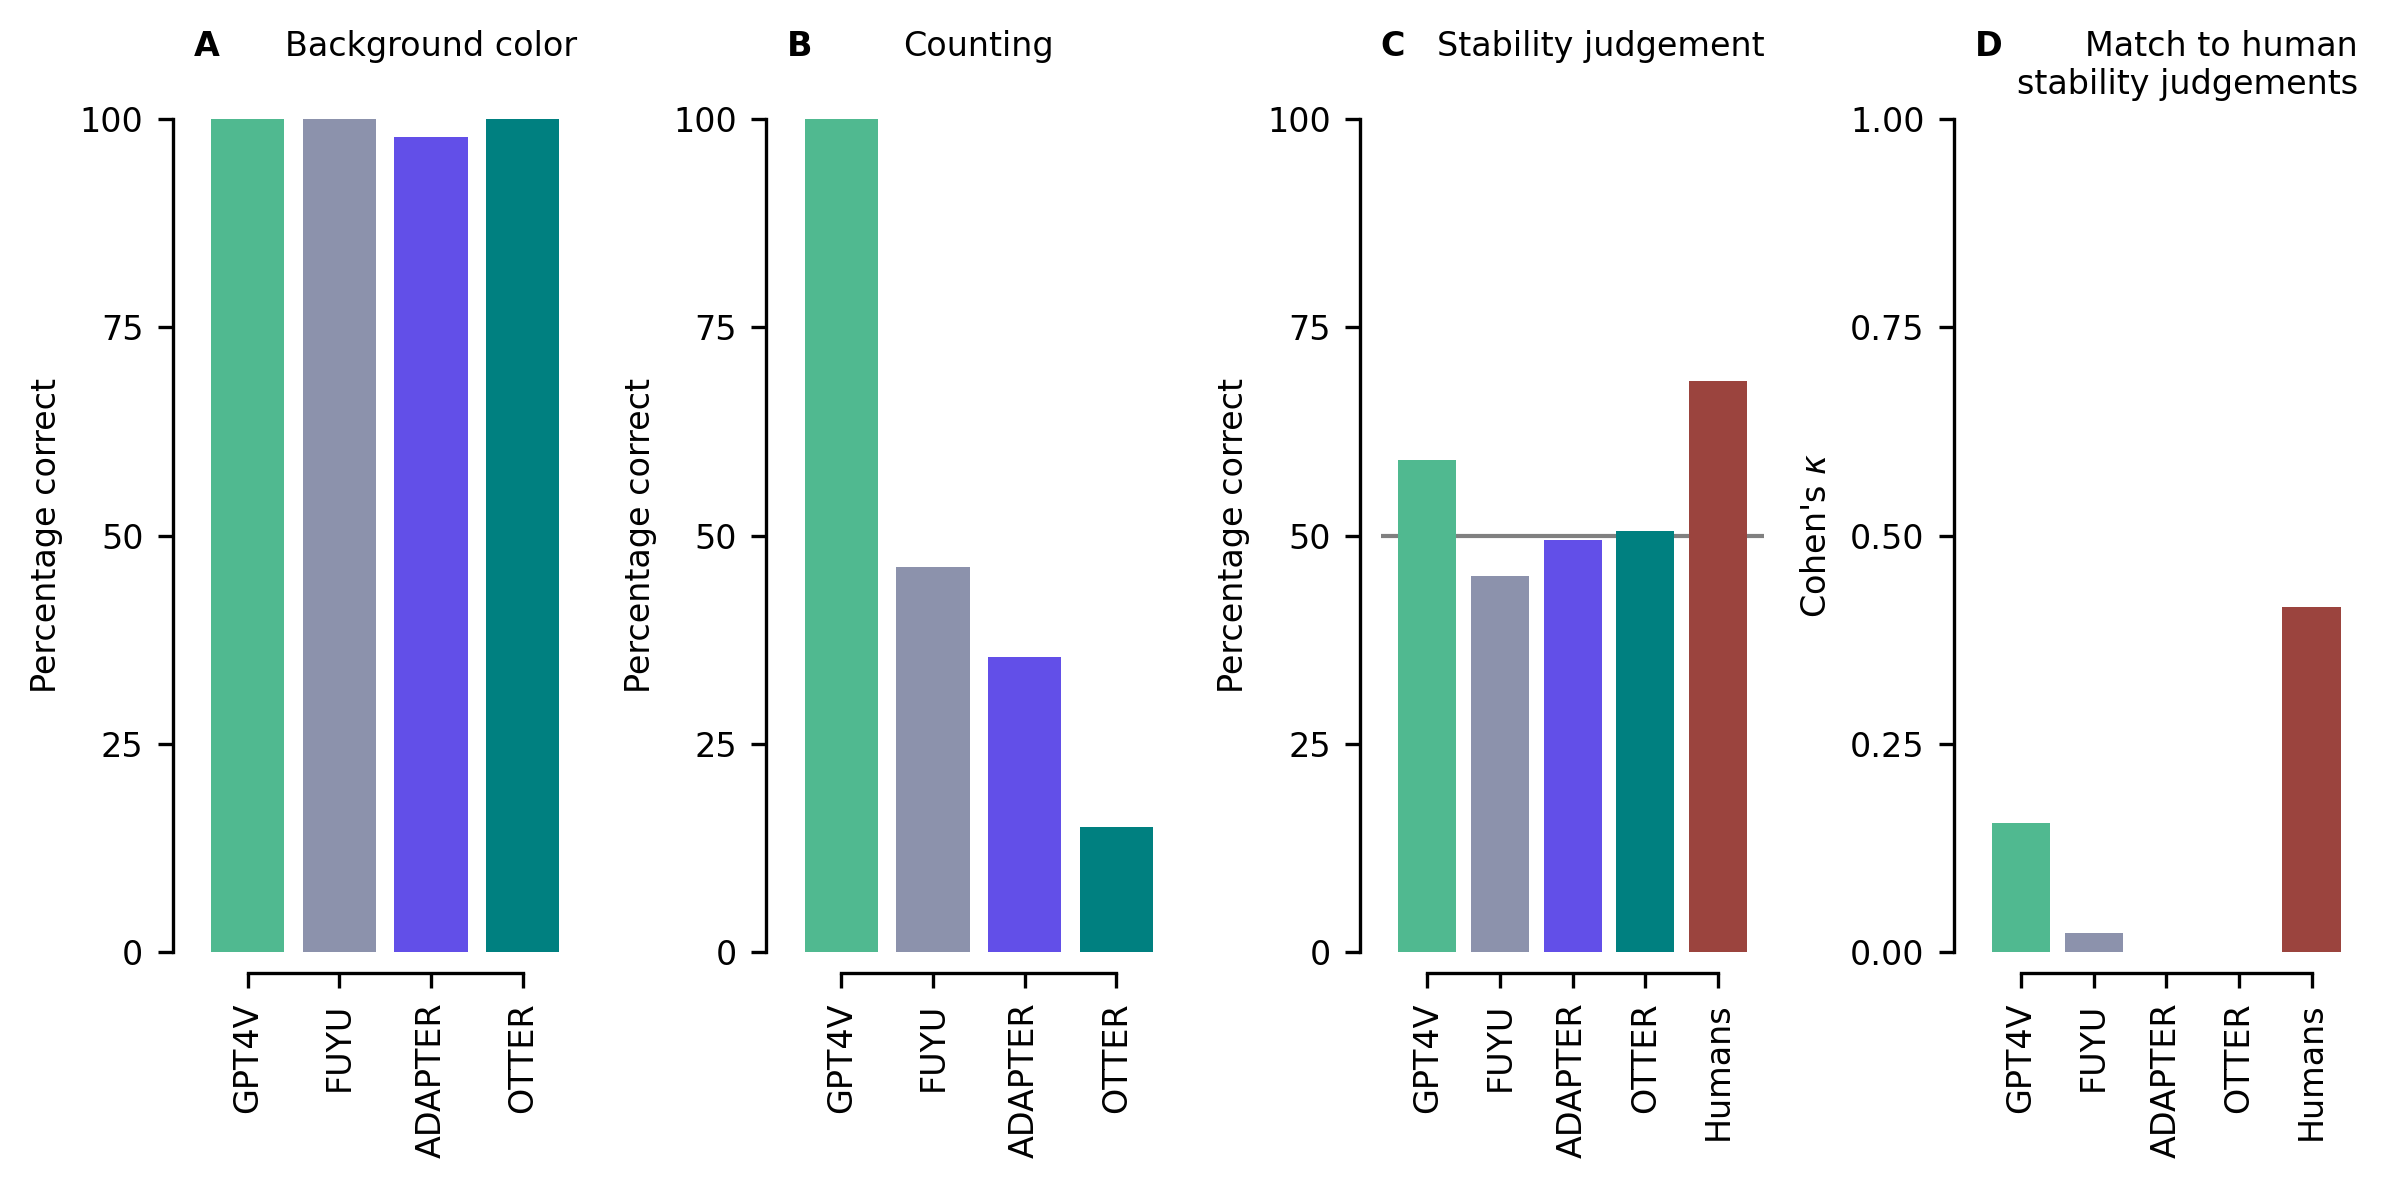

In [30]:
# Prepare plot
models = percentages_correct.columns[1:]
num_subjects = len(models)
fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(8,4))  

# Plot A
axs[0].bar(np.arange(num_subjects), percentages_correct[percentages_correct["Experiment"] == 1].values[0][1:]*100, zorder=2, color=model_colors)
axs[0].set_title("Background color\n", loc="right")
axs[0].set_title("A\n", fontweight='bold', loc='left', fontsize='medium')
axs[0].set_ylabel("Percentage correct")
axs[0].set_ylim(0, 100)
axs[0].set_yticks(np.arange(0, 110, 25))
axs[0].set_xticks(np.arange(num_subjects))
axs[0].set_xticklabels(np.hstack(("GPT4V", models[1:])), rotation=90)

# Plot B
axs[1].bar(np.arange(num_subjects), percentages_correct[percentages_correct["Experiment"] == 2].values[0][1:]*100, zorder=2, color=model_colors)
axs[1].set_title("Counting\n", loc="center")
axs[1].set_title("B\n", fontweight='bold', loc='left', fontsize='medium')
axs[1].set_ylabel("Percentage correct")
axs[1].set_ylim(0, 100)
axs[1].set_yticks(np.arange(0, 110, 25))
axs[1].set_xticks(np.arange(num_subjects))

# Plot C
axs[2].bar(np.arange(num_subjects+1), np.hstack((percentages_correct[percentages_correct["Experiment"] == 3].values[0][1:]*100, human_accs.mean()*100)), zorder=2, color=model_colors)
axs[2].set_title("Stability judgement\n", loc="right")
axs[2].set_title("C\n", fontweight='bold', loc='left', fontsize='medium')
axs[2].set_ylabel("Percentage correct")
axs[2].set_ylim(0, 100)
axs[2].set_yticks(np.arange(0, 110, 25))
axs[2].set_xticks(np.arange(num_subjects+1))
axs[2].axhline(50, xmin=0, xmax=num_subjects, color="gray", linestyle="-", linewidth=1.0, zorder=1)

# Plot D
axs[3].bar(np.arange(num_subjects+1), np.hstack((human_judgement_similarity, np.mean(human_kappas))), zorder=2, color=model_colors)
axs[3].set_title("Match to human\nstability judgements", loc="right")
axs[3].set_title("D\n", fontweight='bold', loc='left', fontsize='medium')
axs[3].set_ylabel(r"Cohen's $\kappa$")
axs[3].set_ylim(0, 1)
axs[3].set_yticks(np.arange(0.0, 1.1, 0.25))
axs[3].set_xticks(np.arange(num_subjects+1))

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(np.hstack(("GPT4V", models[1:])), rotation=90)
axs[1].set_xticklabels(np.hstack(("GPT4V", models[1:])), rotation=90)
axs[2].set_xticklabels(np.hstack((np.hstack(("GPT4V", models[1:])), "Humans")), rotation=90)
axs[3].set_xticklabels(np.hstack((np.hstack(("GPT4V", models[1:])), "Humans")), rotation=90)
plt.savefig("lerer_main.pdf", dpi=300)

## Make example plot

In [15]:
# For experiment 3 get images all humans agreed that the tower would definitely fall or stay
human_easy_inds = np.where(np.abs(df.loc[df["Experiment"] == 3, "H1":].astype(float).mean(axis=1, skipna=True) - df.loc[df["Experiment"] == 3, "GT"].astype(float)) == 0)
human_easy_imgs = df.loc[df["Experiment"] == 3, "Image"].iloc[human_easy_inds]
human_hard_inds = np.where(np.abs(df.loc[df["Experiment"] == 3, "H1":].astype(float).mean(axis=1, skipna=True) - df.loc[df["Experiment"] == 3, "GT"].astype(float)) == 1)
human_hard_imgs = df.loc[df["Experiment"] == 3, "Image"].iloc[human_hard_inds]


# For experiment 3 get images all models got either right or wrong
model_easy_inds = np.where(np.abs(df.loc[df["Experiment"] == 3, "GPT-4V-B":"H1"].astype(float).mean(axis=1, skipna=True) - df.loc[df["Experiment"] == 3, "GT"].astype(float)) == 0)
model_easy_imgs = df.loc[df["Experiment"] == 3, "Image"].iloc[model_easy_inds]
model_hard_inds = np.where(np.abs(df.loc[df["Experiment"] == 3, "GPT-4V-B":"H1"].astype(float).mean(axis=1, skipna=True) - df.loc[df["Experiment"] == 3, "GT"].astype(float)) == 1)
model_hard_imgs = df.loc[df["Experiment"] == 3, "Image"].iloc[model_hard_inds]

# Get image numbers
easyhumanhardmodels = np.intersect1d(human_easy_imgs, model_hard_imgs)
easyhumaneasymodels = np.intersect1d(human_easy_imgs, model_easy_imgs) 
hardhumanhardmodels = np.intersect1d(human_hard_imgs, model_hard_imgs)  
hardhumaneasymodels = np.intersect1d(human_hard_imgs, model_easy_imgs)  


# For experiment 3 get images all models got either right or wrong
gpt4v_easy_inds = np.where(np.abs(df.loc[df["Experiment"] == 3, "GPT-4V-B"].astype(float) - df.loc[df["Experiment"] == 3, "GT"].astype(float)) == 0)
gpt4v_easy_imgs = df.loc[df["Experiment"] == 3, "Image"].iloc[gpt4v_easy_inds]
gpt4v_hard_inds = np.where(np.abs(df.loc[df["Experiment"] == 3, "GPT-4V-B"].astype(float) - df.loc[df["Experiment"] == 3, "GT"].astype(float)) == 1)
gpt4v_hard_imgs = df.loc[df["Experiment"] == 3, "Image"].iloc[gpt4v_hard_inds]

# Get image numbers
easyhumanhardgpt4v = np.intersect1d(human_easy_imgs, gpt4v_hard_imgs)
easyhumaneasygpt4v = np.intersect1d(human_easy_imgs, gpt4v_easy_imgs)
hardhumanhardgpt4v = np.intersect1d(human_hard_imgs, gpt4v_hard_imgs) 
hardhumaneasygpt4v = np.intersect1d(human_hard_imgs, gpt4v_easy_imgs) 


# Get images that are either hard or easy for humans and models
print(f"Images that are easy for humans but hard for all models: {easyhumanhardmodels}")
print(f"Images that are easy for humans and easy for all models: {easyhumaneasymodels}")
print(f"Images that are hard for humans but hard for all models: {hardhumanhardmodels}")
print(f"Images that are hard for humans and easy for all models: {hardhumaneasymodels}")

# Get images that are either hard or easy for humans and GPT-4V
print(f"Images that are easy for humans but hard for GPT4-V: {easyhumanhardgpt4v}")
print(f"Images that are easy for humans and easy for GPT4-V: {easyhumaneasygpt4v}")
print(f"Images that are hard for humans but hard for GPT4-V: {hardhumanhardgpt4v}")
print(f"Images that are hard for humans and easy for GPT4-V: {hardhumaneasygpt4v}")

Images that are easy for humans but hard for all models: [372]
Images that are easy for humans and easy for all models: [  3  38 194 299 458]
Images that are hard for humans but hard for all models: [121 393 454]
Images that are hard for humans and easy for all models: [  7 131]
Images that are easy for humans but hard for GPT4-V: [ 63 125 173 254 310 325 372 413 434 437 474 478 499 505 509]
Images that are easy for humans and easy for GPT4-V: [  3  20  38  64 105 167 188 194 240 260 261 279 295 299 311 326 416 417
 458 485 504 510]
Images that are hard for humans but hard for GPT4-V: [ 42 121 234 319 392 393 454 481]
Images that are hard for humans and easy for GPT4-V: [  7  91 131 147 152 214 238 258 479 484]


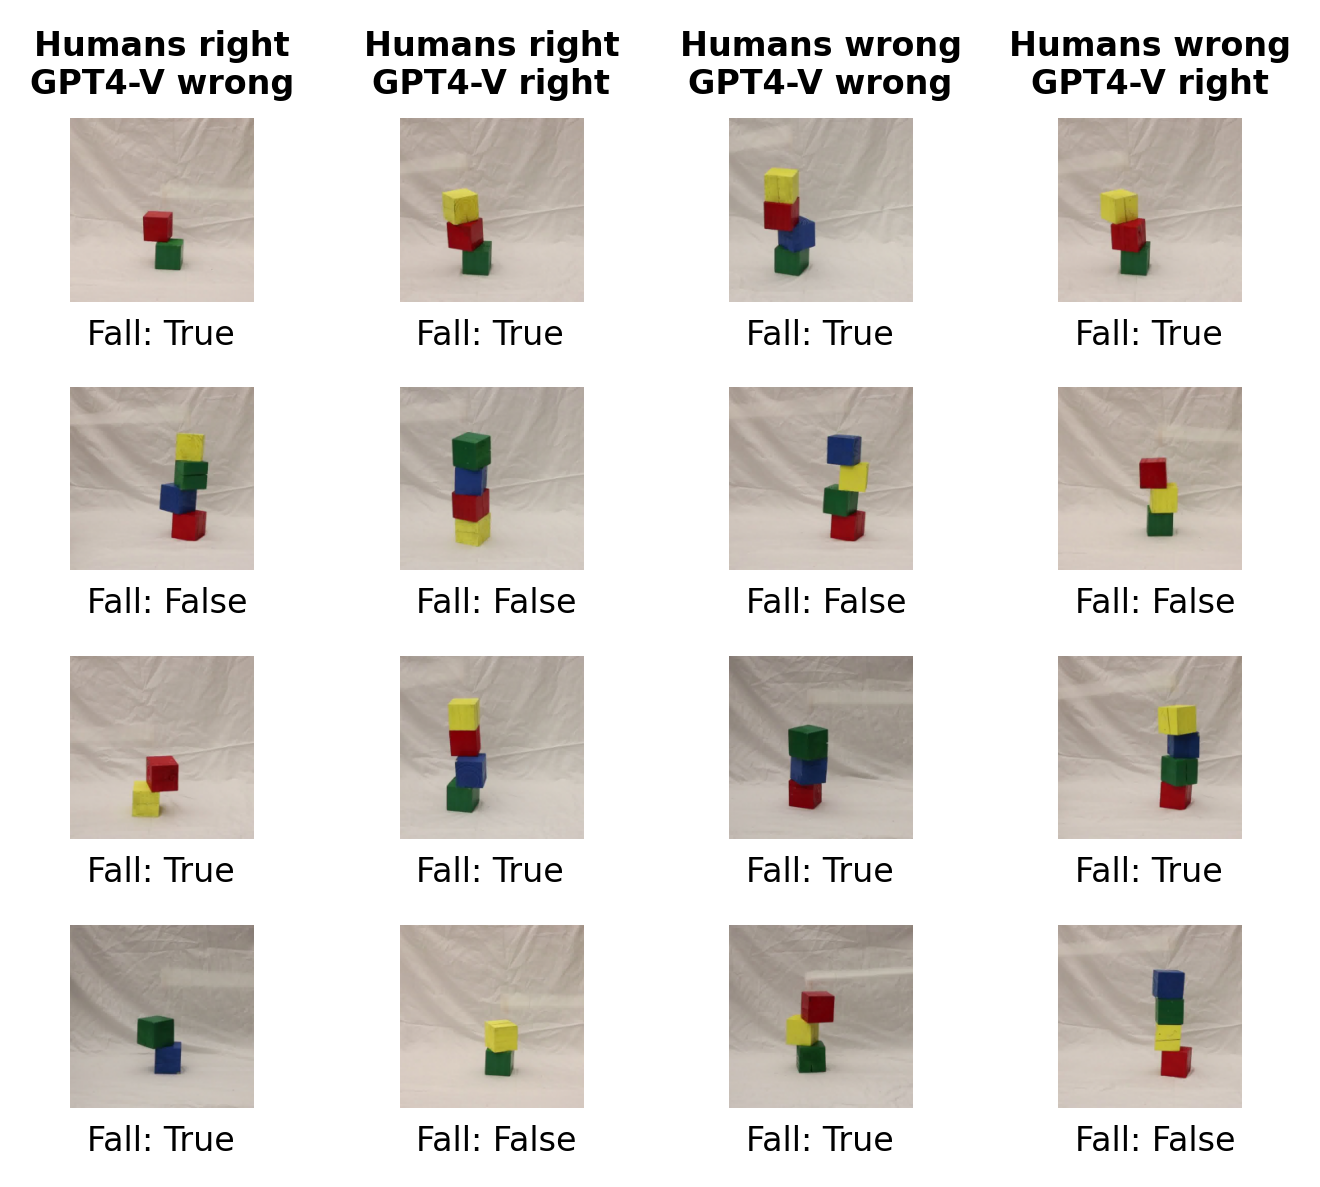

In [16]:
# Prepare plot
models = percentages_correct.columns[1:]
num_subjects = len(models)
fig, axs = plt.subplots(4, 4, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: Easy for humans, hard for models
for row in range(4):
    axs[row, 0].imshow(plt.imread(f"eval/images/lerer/img_frame1_{easyhumanhardgpt4v[row]}.png"))
    fall = bool(df.loc[(df["Experiment"] == 3) & (df["Image"] == easyhumanhardgpt4v[row]), "GT"].values.astype(int))
    axs[row, 0].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 0].axis("off")

    axs[row, 1].imshow(plt.imread(f"eval/images/lerer/img_frame1_{easyhumaneasygpt4v[row]}.png"))
    fall = bool(df.loc[(df["Experiment"] == 3) & (df["Image"] == easyhumaneasygpt4v[row]), "GT"].values.astype(int))
    axs[row, 1].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 1].axis("off")

    axs[row, 2].imshow(plt.imread(f"eval/images/lerer/img_frame1_{hardhumanhardgpt4v[row]}.png"))
    fall = bool(df.loc[(df["Experiment"] == 3) & (df["Image"] == hardhumanhardgpt4v[row]), "GT"].values.astype(int))
    axs[row, 2].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 2].axis("off")

    axs[row, 3].imshow(plt.imread(f"eval/images/lerer/img_frame1_{hardhumaneasygpt4v[row]}.png"))
    fall = bool(df.loc[(df["Experiment"] == 3) & (df["Image"] == hardhumaneasygpt4v[row]), "GT"].values.astype(int))
    axs[row, 3].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 3].axis("off")
    

# Set column titles
axs[0, 0].set_title("Humans right\nGPT4-V wrong", fontweight="bold")
axs[0, 1].set_title("Humans right\nGPT4-V right", fontweight="bold")
axs[0, 2].set_title("Humans wrong\nGPT4-V wrong", fontweight="bold")
axs[0, 3].set_title("Humans wrong\nGPT4-V right", fontweight="bold")
plt.savefig("lerer_examples.pdf", dpi=300)